<a href="https://colab.research.google.com/github/Fadiabdf/OPT/blob/main/TP3/metaheuristique_RL_(voisinages).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsplib95
!pip install springpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.1.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
nx-cugraph-cu12 25.2.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cubla

In [ ]:
import numpy as np
import xml.etree.ElementTree as ET
import time
from math import ceil
import tsplib95
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import math
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
!ls

berlin52.xml  sample_data  swiss42.xml


chrager le fichier de test (*.xml)


In [ ]:
# Charger et parser le fichier XML
instance = 'berlin52.xml'  # le benchmark utilisé
problem = ET.parse(instance)
root = problem.getroot()
graphe = {}

# Extraire les sommets et leurs distances
for i, sommet in enumerate(root.find('graph').findall('vertex')):
    aretes = {}
    for arete in sommet.findall('edge'):
        cible = int(arete.text)
        cout = float(arete.get('cost'))  # Distance
        aretes[cible] = cout
    graphe[i] = aretes

nombre_sommets = len(graphe)
print(f"Nombre total de villes : {nombre_sommets}")

Nombre total de villes : 52


construire la matrice de distances à partir du fichier du test et saisir le **nombre_sommets** à prendre


In [ ]:
# Initialiser une matrice de distances avec des valeurs infinies
matrice_distances = np.full((nombre_sommets, nombre_sommets), np.inf)
matrice_distances = matrice_distances.astype(int)

# Remplir la matrice de distances avec les coûts extraits
for i, aretes in graphe.items():
    for j, cout in aretes.items():
        matrice_distances[i, j] = cout

# Définir la diagonale à zéro (distance d'un sommet à lui-même)
np.fill_diagonal(matrice_distances, 0)

# Sélectionner un sous-ensemble de la matrice pour les tests
#------------------------------------------------------------------------
n_sous_ensemble = nombre_sommets  # Nombre de sommets à inclure dans le sous-ensemble
print(f"Nombre de nœuds à prendre pour le test : {n_sous_ensemble}")
sous_ensemble_matrice = matrice_distances[:n_sous_ensemble, :n_sous_ensemble]
#------------------------------------------------------------------------

# Convertir la matrice en liste pour une utilisation ultérieure
matrice_distances_liste = matrice_distances.tolist()
sous_ensemble_matrice_liste = sous_ensemble_matrice.tolist()

# Afficher le sous-ensemble de la matrice
print(sous_ensemble_matrice)

Nombre de nœuds à prendre pour le test : 52
[[   0  666  281 ...  217  789 1220]
 [ 666    0  649 ...  596 1421 1716]
 [ 281  649    0 ...  463  995 1483]
 ...
 [ 217  596  463 ...    0  829 1150]
 [ 789 1421  995 ...  829    0  624]
 [1220 1716 1483 ... 1150  624    0]]


<ipython-input-50-fd00d4f0f6a9>:3: RuntimeWarning: invalid value encountered in cast
  matrice_distances = matrice_distances.astype(int)  # Convertit en entiers


visualiser le graph

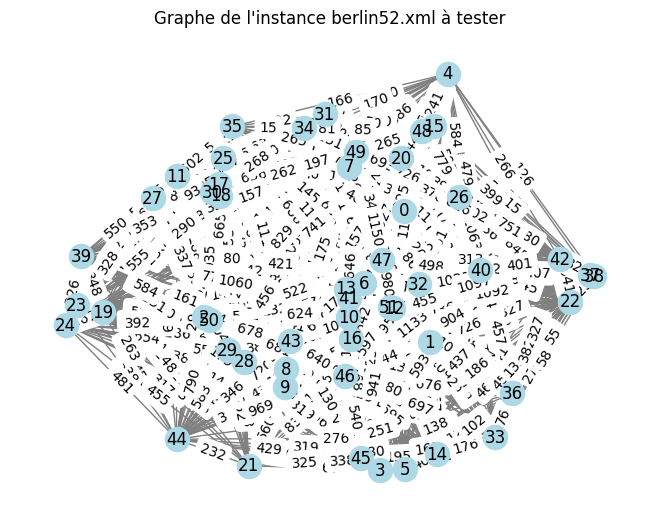

In [ ]:
import networkx as nx

# Créer un graphe à partir de la matrice de distances
G = nx.Graph()
for i in range(len(sous_ensemble_matrice_liste)):
    for j in range(len(sous_ensemble_matrice_liste[i])):
        if i != j:
            G.add_edge(i, j, weight= sous_ensemble_matrice_liste[i][j])

# Dessiner le graphe
pos = nx.spring_layout(G)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graphe de l'instance " +instance+ " à tester")
plt.show()

# **Métaheuristiques RL (recherche locale)**

#1. **RS : Récuit Simulé (Simulated Annealing)**


# **1. Principe :**
Le recuit simulé est une métaheuristique inspirée de la thermodynamique, notamment du refroidissement lent des métaux.
L’idée est de parcourir l’espace des solutions en permettant parfois d'accepter des solutions moins bonnes, afin d’éviter les minimums locaux.

# **Étapes du Recuit Simulé pour le PVC :**

* **Solution initiale :**Générer un parcours aléatoire (ex : [0, 2, 1, 3]).

* **Évaluation :** Calculer la distance totale du parcours.

* **Voisinage :** Générer une solution voisine en permutant deux villes.

* **Critère d’acceptation :**

   * Si la solution est meilleure : on l'accepte.

   * Si elle est moins bonne : on peut quand même l'accepter avec une probabilité :

𝑃
=
𝑒
−
Δ
/
𝑇


où Δ est la dégradation du coût, et T est la température.

* **Refroidissement :** Diminuer progressivement la température (ex : T *= alpha).




# **Paramètres du Recuit Simulé :**

* T0 **(Température initiale)**	Contrôle la probabilité d'accepter de mauvaises solutions au début (exploration).
* alpha **(Facteur de refroidissement)**	Détermine la vitesse de diminution de la température (T *= alpha).
* T_min **(Température minimale)**	Seuil d'arrêt pour éviter une boucle infinie quand T devient trop faible.
* max_iter **(Nombre d’itérations max)**	Limite le nombre total d’itérations.

**fonctions de base**

In [ ]:
# fonction pour calculer la distance totale du circuit
def total_distance(route, distance_matrix):
    return sum(
        distance_matrix[route[i]][route[(i + 1) % len(route)]]
        for i in range(len(route))
    )

# fonction pour créer un voisin en échangeant deux villes
def generate_neighbor(route):
    a, b = random.sample(range(len(route)), 2)
    neighbor = route.copy()
    neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
    return neighbor

# **RS:**

In [ ]:
def simulated_annealing(distance_matrix, T0=1000, alpha=0.995, T_min=1e-3, max_iter=10000):

    n = len(distance_matrix)                                         # nombre de villes
    current_solution = list(range(n))                                # crée une séquence de villes (solution initiale)
    random.shuffle(current_solution)                                 # mélange la séquence de villes
    current_cost = total_distance(current_solution, distance_matrix) # calculer son coût total

    best_solution = current_solution[:]
    best_cost = current_cost

    T = T0
    iteration = 0
    cost_history = [current_cost]

    while T > T_min and iteration < max_iter:
        neighbor = generate_neighbor(current_solution)              # génèrer une solution voisine
        neighbor_cost = total_distance(neighbor, distance_matrix)
        delta = neighbor_cost - current_cost                         # la variation de coût

        if delta < 0 or random.random() < np.exp(-delta / T):
            # accepter la solution voisine
            current_solution = neighbor
            current_cost = neighbor_cost
            # Si cette solution est la meilleure jamais trouvée, on la stocke comme meilleure solution globale
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

        cost_history.append(best_cost) # garder une trace de la meilleure valeur trouvée à chaque itération
        T *= alpha                     # on diminue la temp avec un facteur de refroidissement
        iteration += 1

    return best_solution, best_cost, cost_history


In [ ]:
def try_multiple_parameters(distance_matrix, instance_name, n_tries=5):
    results = []
    for i in range(n_tries):
        # Générer des paramètres aléatoires
        T0 = random.uniform(500, 1500)
        alpha = random.uniform(0.990, 0.999)
        T_min = random.uniform(1e-4, 1e-2)
        max_iter = random.randint(3000, 10000)

        print(f"\n[Try {i+1}] Parameters: T0={T0:.2f}, alpha={alpha:.4f}, T_min={T_min:.5f}, max_iter={max_iter}")

        start_time = time.time()
        solution, cost, history = simulated_annealing(distance_matrix, T0, alpha, T_min, max_iter)
        exec_time = time.time() - start_time

        results.append({
            'solution': solution,
            'cost': cost,
            'time': exec_time,
            'params': (T0, alpha, T_min, max_iter),
            'history': history
        })

    # Choisir le meilleur résultat en fonction du coût
    best = min(results, key=lambda r: r['cost'])
    print(f"\n--- Meilleur résultat pour {instance_name} ---")
    print("Distance optimale trouvée :", best['cost'])
    print("Tournée optimale :", best['solution'])
    print("Temps d'exécution : {:.6f} secondes".format(best['time']))
    print("Paramètres :", best['params'])

    return best, results

#best_result = try_multiple_parameters(matrice_distances_liste, instance)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D  # CORRIGÉ
import seaborn as sns

def visualize_sa_results(results, instance_name):
    # Créer un DataFrame pour faciliter l'analyse
    df = pd.DataFrame([
        {
            'Try': i + 1,
            'T0': r['params'][0],
            'Alpha': r['params'][1],
            'T_min': r['params'][2],
            'Max Iter': r['params'][3],
            'Cost': r['cost'],
            'Execution Time (s)': r['time']
        } for i, r in enumerate(results)
    ])

    # Afficher un tableau des résultats
    print("\nTableau comparatif des essais :")
    display(df.sort_values(by='Cost'))

    # Courbe d'évolution du coût
    plt.figure(figsize=(12, 6))
    for i, res in enumerate(results):
        plt.plot(res['history'], label=f'Try {i+1} (Cost={res["cost"]:.2f})')
    plt.title(f"Évolution du coût - Recuit simulé - {instance_name}")
    plt.xlabel("Itération")
    plt.ylabel("Coût")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    return df


# **les tests**


[Try 1] Parameters: T0=799.53, alpha=0.9961, T_min=0.00635, max_iter=6979

[Try 2] Parameters: T0=678.40, alpha=0.9929, T_min=0.00292, max_iter=3111

[Try 3] Parameters: T0=1408.18, alpha=0.9980, T_min=0.00544, max_iter=8128

[Try 4] Parameters: T0=1408.98, alpha=0.9909, T_min=0.00076, max_iter=7077

[Try 5] Parameters: T0=816.39, alpha=0.9944, T_min=0.00030, max_iter=4209

--- Meilleur résultat pour berlin52.xml ---
Distance optimale trouvée : 9365
Tournée optimale : [2, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 47, 36, 39, 33, 34, 35, 0, 31, 48, 38, 37, 23, 4, 5, 14, 3, 24, 45, 43, 44, 40, 18, 17, 21, 15, 28, 49, 29, 1, 6, 41, 16, 20, 22, 19, 30]
Temps d'exécution : 0.067070 secondes
Paramètres : (1408.180253908678, 0.9979891506600683, 0.005442608920262166, 8128)

Tableau comparatif des essais :


,Try,T0,Alpha,T_min,Max Iter,Cost,Execution Time (s)
2,3,1408.180254,0.997989,0.005443,8128,9365,0.067070
4,5,816.391218,0.994438,0.000304,4209,11391,0.030987
0,1,799.526577,0.996094,0.006348,6979,11445,0.033277
1,2,678.395850,0.992910,0.002915,3111,12793,0.019099
3,4,1408.978693,0.990947,0.000763,7077,14420,0.017303


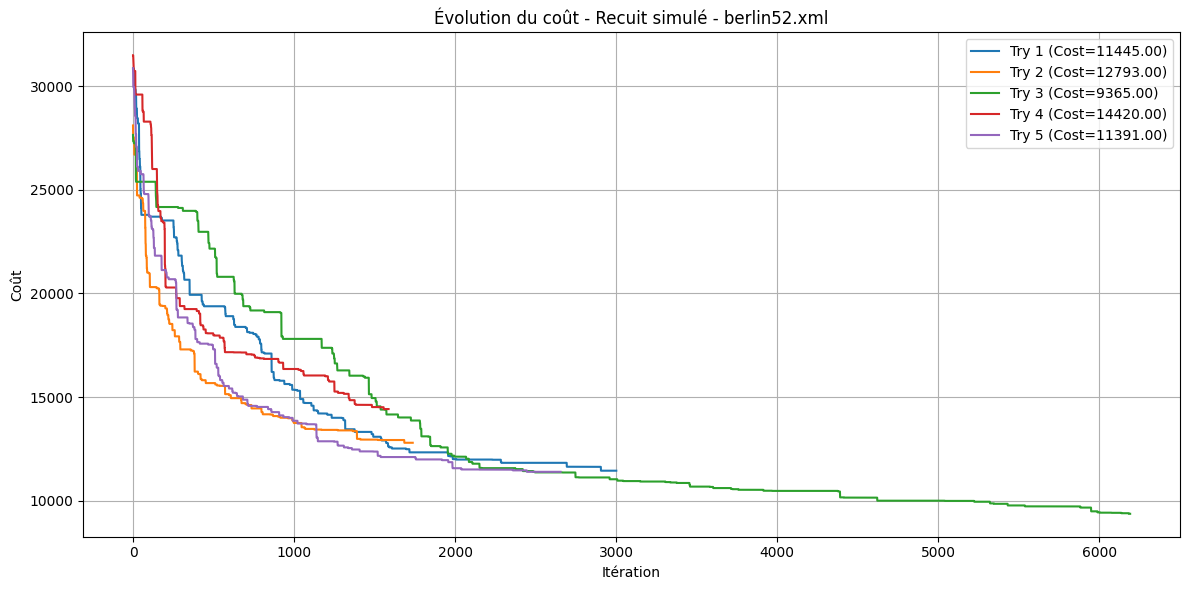

In [ ]:
best_result, results = try_multiple_parameters(matrice_distances_liste, instance)
df_results = visualize_sa_results(results, instance)

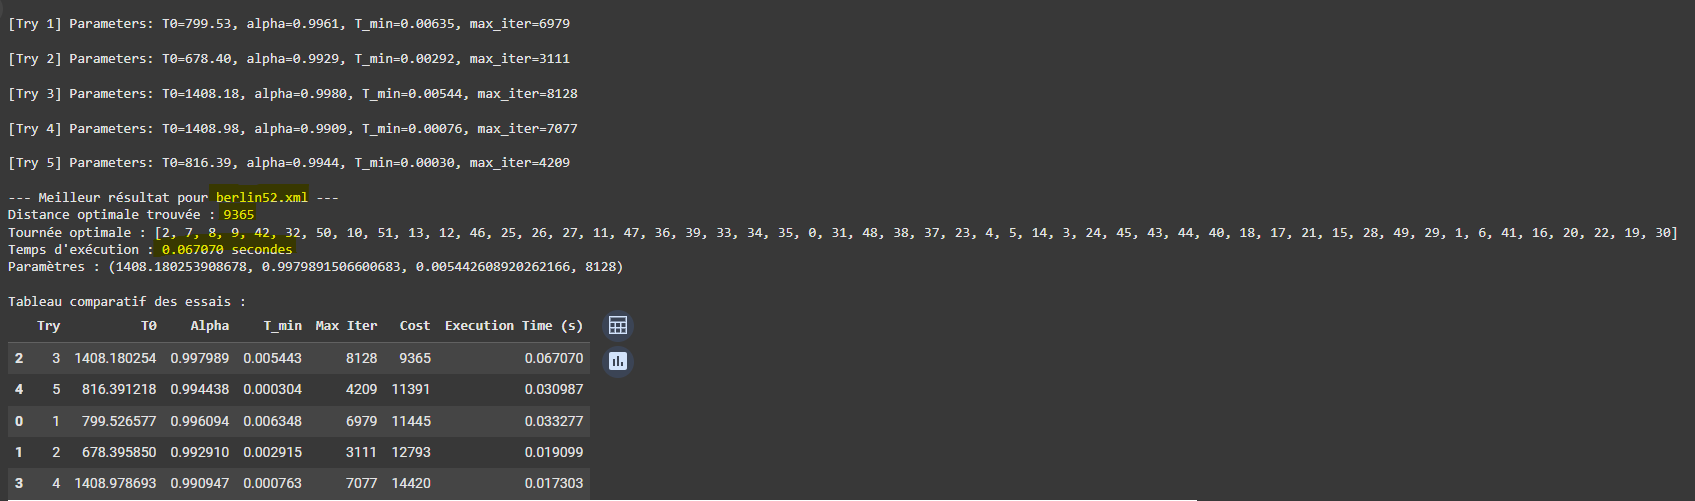

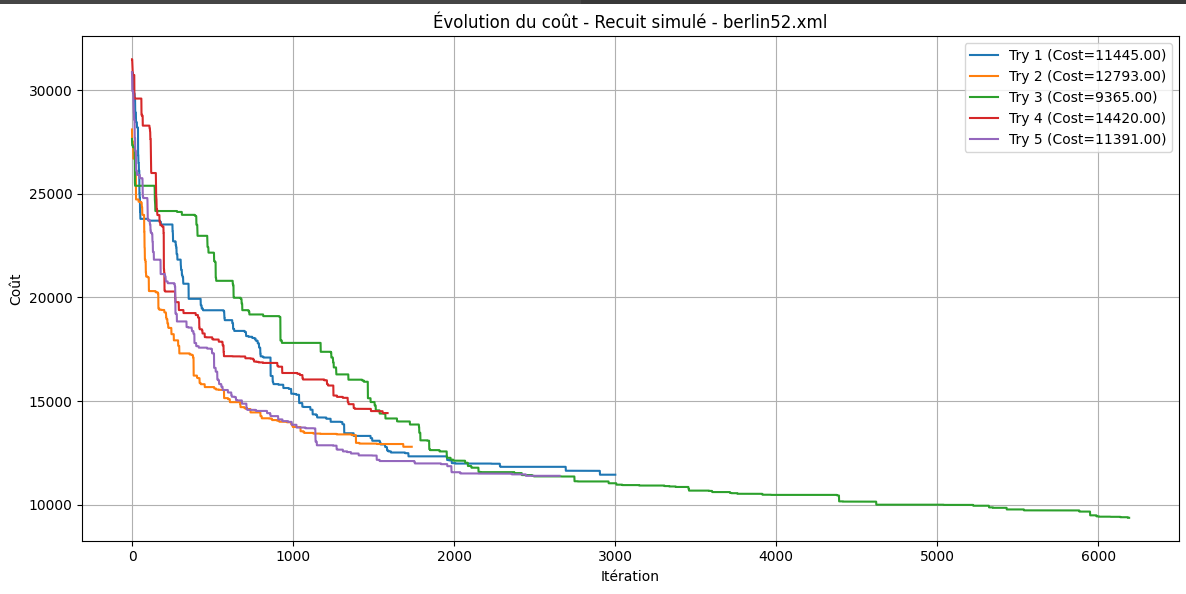

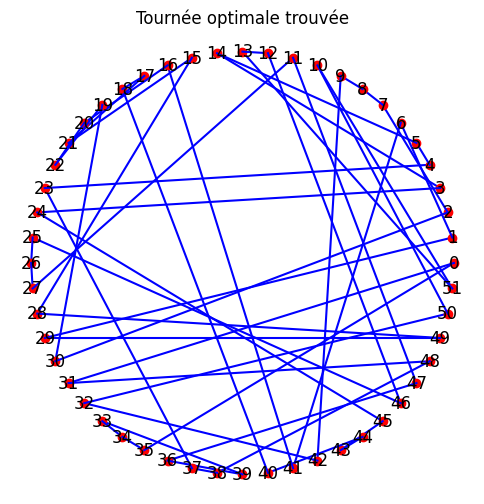

In [ ]:
def afficher_tournee(tournee, titre="Tournée optimale trouvée"):
    import matplotlib.pyplot as plt
    import numpy as np

    n = len(tournee)

    positions = np.array([
        [np.cos(2 * np.pi * i / n), np.sin(2 * np.pi * i / n)]
        for i in range(n)
    ])

    plt.figure(figsize=(6, 6))

    for i, ville in enumerate(tournee):
        x, y = positions[ville]
        plt.plot(x, y, 'ro')
        plt.text(x, y, str(ville), fontsize=12, ha='center', va='center', color='black')
        suivante = tournee[(i + 1) % n]
        x_next, y_next = positions[suivante]
        plt.plot([x, x_next], [y, y_next], 'b-')

    plt.title(titre)
    plt.axis('equal')
    plt.axis('off')
    plt.show()


afficher_tournee(best_result['solution'])


# 2.**Recherche Tabou**

**1. Principe :**
* La recherche tabou est une métaheuristique inspirée du raisonnement humain et du concept de mémoire à court terme. Contrairement aux méthodes locales classiques, elle évite les cycles en interdisant temporairement certains mouvements récemment effectués.

# **Objectif :**
* Empêcher l’algorithme de “tourner en rond” en stockant les derniers mouvements dans une liste taboue, tout en permettant des exceptions stratégiques (aspiration) pour ne pas bloquer l’amélioration.

# **Étapes de la Recherche Tabou pour le PVC :**

**Solution initiale :**
* Générer un parcours aléatoire (ex : [0, 2, 1, 3, 4]).

**Évaluation :**
* Calculer la distance totale du parcours avec la matrice de distances.

**Voisinage :**
* Générer tous les voisins via permutation de deux villes.

**Liste taboue :**
* Mémoriser les mouvements (paires de villes échangées) récents.
Ces mouvements sont interdits temporairement pour tabu_tenure itérations.

**Critère d’acceptation :**

* Choisir le meilleur voisin non tabou, ou

* Une solution taboue si elle est meilleure que la meilleure jamais trouvée (aspiration).

**Mise à jour :**

* La solution courante devient le voisin admissible.

* Le mouvement est ajouté dans la liste taboue avec expiration à iteration + tabu_tenure.

* Mettre à jour la meilleure solution globale si besoin.

**Nettoyage :**

* À chaque itération, supprimer les entrées expirées de la liste tabou



# **Paramètres de la Recherche Tabou**
* max_iter → Nombre maximal d’itérations de l’algorithme

* tabu_tenure → Nombre d’itérations pendant lesquelles un mouvement est interdit

* tabu_list → Mémoire taboue : stocke les mouvements récents interdits (sous forme de paires de villes échangées) structurée en (clé = échange, valeur = itération d’expiration).


fonctions de base

In [ ]:
# fonction pour génèrer tous les voisins possibles d'une solution donnée
def get_neighbors(route):
    neighbors = []            # les solutions voisines
    for i in range(len(route)):
        for j in range(i + 1, len(route)):
            neighbor = route.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append((neighbor, (i, j))) # liste complète de voisins possibles, accompagné de l'indice des mouvements qui ont mené à cette solution
    return neighbors

In [ ]:
def tabu_search(distance_matrix, max_iter=500, tabu_tenure=10):
    n = len(distance_matrix)
    current_solution = list(range(n))
    random.shuffle(current_solution)
    current_cost = total_distance(current_solution, distance_matrix)

    best_solution = current_solution[:]
    best_cost = current_cost

    tabu_list = {}  # un dictionnaire où les clés sont les mouvements effectués, et les valeurs sont les itérations auxquelles ces mouvements sont interdits
    cost_history = [current_cost]

    for iteration in range(max_iter):
        neighbors = get_neighbors(current_solution)
        neighbors = sorted(neighbors, key=lambda x: total_distance(x[0], distance_matrix))  # trie les voisins en fonction de leur coût

        for neighbor, move in neighbors:
            move_tuple = tuple(sorted(move))
            neighbor_cost = total_distance(neighbor, distance_matrix)

            if (move_tuple not in tabu_list) or (neighbor_cost < best_cost):  # Aspiration
                current_solution = neighbor
                current_cost = neighbor_cost

                if neighbor_cost < best_cost:
                    best_solution = neighbor
                    best_cost = neighbor_cost

                tabu_list[move_tuple] = iteration + tabu_tenure
                break

        # Mise à jour de la liste taboue  en supprimant les mouvements qui ne sont plus tabous (càd dont la "tenure" a expiré)
        tabu_list = {m: t for m, t in tabu_list.items() if t > iteration}
        cost_history.append(best_cost)

    return best_solution, best_cost, cost_history


In [ ]:
def try_multiple_tabu(distance_matrix, instance_name, n_tries=5):
    results = []

    for i in range(n_tries):
        max_iter = random.randint(300, 1000)
        tabu_tenure = random.randint(5, 30)

        print(f"\n[Try {i+1}] Paramètres: max_iter={max_iter}, tabu_tenure={tabu_tenure}")

        start_time = time.time()
        solution, cost, history = tabu_search(distance_matrix, max_iter=max_iter, tabu_tenure=tabu_tenure)
        exec_time = time.time() - start_time

        results.append({
            'solution': solution,
            'cost': cost,
            'time': exec_time,
            'params': (max_iter, tabu_tenure),
            'history': history
        })

    # Choix de la meilleure solution
    best = min(results, key=lambda r: r['cost'])

    print(f"\n--- Meilleur résultat pour {instance_name} ---")
    print("Distance optimale :", best['cost'])
    print("Solution optimale :", best['solution'])
    print("Temps d'exécution : {:.6f}s".format(best['time']))
    print("Paramètres :", best['params'])

    return best, results


In [ ]:
def visualize_tabu_results(results, instance_name):
    import matplotlib.pyplot as plt
    import pandas as pd
    from mpl_toolkits.mplot3d import Axes3D

    df = pd.DataFrame([
        {
            'Try': i + 1,
            'Max Iter': r['params'][0],
            'Tabu Tenure': r['params'][1],
            'Cost': r['cost'],
            'Execution Time (s)': r['time']
        } for i, r in enumerate(results)
    ])

    # Affichage du tableau
    print("\n🧾 Tableau des résultats :")
    display(df.sort_values(by='Cost'))

    # Courbes de convergence
    plt.figure(figsize=(10, 5))
    for i, res in enumerate(results):
        plt.plot(res['history'], label=f'Try {i+1} (Cost={res["cost"]:.2f})')
    plt.title(f"Évolution du coût - Tabou - {instance_name}")
    plt.xlabel("Itération")
    plt.ylabel("Coût")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df



[Try 1] Paramètres: max_iter=609, tabu_tenure=17

[Try 2] Paramètres: max_iter=499, tabu_tenure=5

[Try 3] Paramètres: max_iter=392, tabu_tenure=19

[Try 4] Paramètres: max_iter=923, tabu_tenure=6

[Try 5] Paramètres: max_iter=979, tabu_tenure=26

--- Meilleur résultat pour berlin52.xml ---
Distance optimale : 9056
Solution optimale : [16, 2, 17, 30, 22, 19, 49, 15, 43, 34, 33, 45, 46, 12, 13, 51, 10, 50, 32, 9, 8, 7, 40, 18, 44, 31, 21, 0, 48, 35, 38, 39, 36, 37, 47, 23, 4, 5, 14, 42, 3, 25, 26, 27, 11, 24, 28, 29, 1, 6, 41, 20]
Temps d'exécution : 10.816200s
Paramètres : (923, 6)

🧾 Tableau des résultats :


,Try,Max Iter,Tabu Tenure,Cost,Execution Time (s)
3,4,923,6,9056,10.816200
0,1,609,17,9139,6.983165
2,3,392,19,9387,3.823087
4,5,979,26,9478,10.895374
1,2,499,5,9570,5.195089


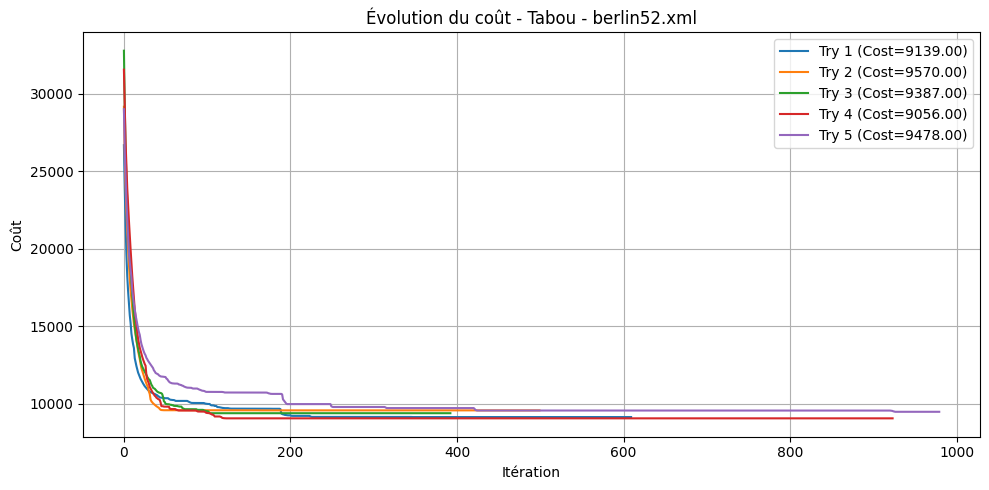

In [ ]:
best_tabu, results_tabu = try_multiple_tabu(matrice_distances_liste, instance)
df_tabu_results = visualize_tabu_results(results_tabu, instance)


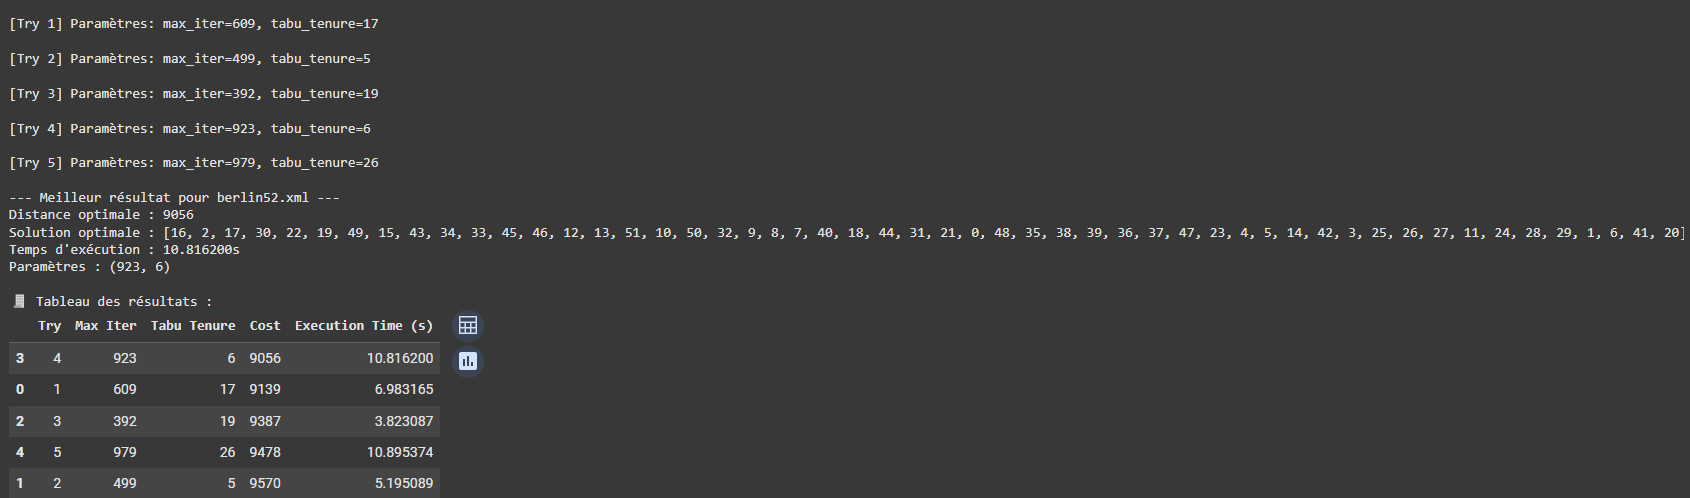

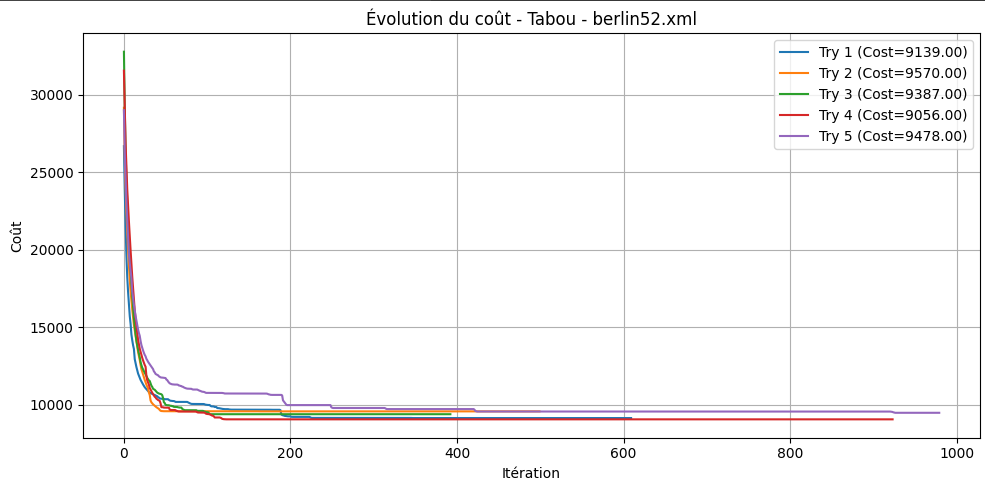

# **3.Hill climbing**

# **Principe**
* le Hill Climbing est une méthode de recherche locale simple et intuitive.
Elle consiste à partir d’une solution initiale et à chercher à l’améliorer étape par étape, en explorant son voisinage et en acceptant uniquement les améliorations.

**Objectif :**
* Atteindre un sommet local, c’est-à-dire une solution dont aucun voisin immédiat n’est meilleur.

# **Étapes**
**Initialisation :**

* Générer une solution initiale aléatoire, ex : [3, 0, 2, 1].

**Évaluation :**

* Calculer le coût total du parcours (somme des distances).

**Génération de voisins :**

* Créer des solutions voisines en permutant deux villes dans la tournée.

**Sélection du meilleur voisin :**

* Évaluer tous les voisins.

* Choisir celui avec le plus faible coût.

**Mise à jour :**

* Si ce voisin est meilleur que la solution actuelle, on le remplace.

* Sinon, on arrête (sommet local atteint).

**Arrêt :**

* Le processus continue tant que l’on trouve des améliorations.

* On s’arrête lorsqu’il n’y a plus de voisin meilleur → convergence vers un optimum local.

fonctions de base


In [ ]:
def calculer_cout(solution, matrice):
    cout = 0
    for i in range(len(solution) - 1):
        cout += matrice[solution[i]][solution[i + 1]]
    cout += matrice[solution[-1]][solution[0]]  # Retour à la ville de départ
    return cout

def generer_voisin(solution):
    voisin = solution[:]
    i, j = random.sample(range(len(solution)), 2)
    voisin[i], voisin[j] = voisin[j], voisin[i]
    return voisin

In [ ]:
def hill_climbing(solution_initiale, matrice, max_iterations=1000):
    solution_actuelle = solution_initiale[:]
    cout_actuel = calculer_cout(solution_actuelle, matrice)
    iteration = 0

    while iteration < max_iterations:
        voisin = generer_voisin(solution_actuelle)
        cout_voisin = calculer_cout(voisin, matrice)

        if cout_voisin < cout_actuel:
            solution_actuelle = voisin
            cout_actuel = cout_voisin
            iteration = 0  # Reset si amélioration
        else:
            iteration += 1

    return solution_actuelle, cout_actuel

In [ ]:
def try_multiple_hillclimbing(distance_matrix, instance_name, n_tries=5):
    n = len(distance_matrix)
    results = []

    for i in range(n_tries):
        nb_restarts = random.randint(10, 50)
        max_iterations = random.randint(500, 2000)

        print(f"\n[Try {i+1}] Paramètres: nb_restarts={nb_restarts}, max_iterations={max_iterations}")
        start_time = time.time()

        meilleure_solution_globale = None
        meilleur_cout_global = float('inf')

        cost_evolution = []

        for _ in range(nb_restarts):
            solution_initiale = list(range(n))
            random.shuffle(solution_initiale)

            solution_locale, cout_locale = hill_climbing(solution_initiale, distance_matrix, max_iterations)
            cost_evolution.append(cout_locale)

            if cout_locale < meilleur_cout_global:
                meilleur_cout_global = cout_locale
                meilleure_solution_globale = solution_locale

        exec_time = time.time() - start_time

        results.append({
            'solution': meilleure_solution_globale,
            'cost': meilleur_cout_global,
            'time': exec_time,
            'params': (nb_restarts, max_iterations),
            'history': cost_evolution
        })

    # Choix de la meilleure config
    best = min(results, key=lambda r: r['cost'])
    print(f"\n--- Meilleur résultat pour {instance_name} ---")
    print("Distance optimale :", best['cost'])
    print("Solution optimale :", best['solution'])
    print("Temps d'exécution : {:.6f}s".format(best['time']))
    print("Paramètres :", best['params'])

    return best, results


In [ ]:
def visualize_hillclimbing_results(results, instance_name):
    import matplotlib.pyplot as plt
    import pandas as pd
    from mpl_toolkits.mplot3d import Axes3D

    df = pd.DataFrame([
        {
            'Try': i + 1,
            'Nb Restarts': r['params'][0],
            'Max Iter': r['params'][1],
            'Cost': r['cost'],
            'Execution Time (s)': r['time']
        } for i, r in enumerate(results)
    ])

    print("\n🧾 Tableau des résultats Hill Climbing :")
    display(df.sort_values(by='Cost'))

    # Courbes des coûts par redémarrage
    plt.figure(figsize=(10, 5))
    for i, res in enumerate(results):
        plt.plot(res['history'], marker='o', label=f'Try {i+1} (Best={res["cost"]:.2f})')
    plt.title(f"Évolution des coûts par redémarrage - Hill Climbing - {instance_name}")
    plt.xlabel("Redémarrages")
    plt.ylabel("Coût")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    return df



[Try 1] Paramètres: nb_restarts=30, max_iterations=1167

[Try 2] Paramètres: nb_restarts=43, max_iterations=1278

[Try 3] Paramètres: nb_restarts=10, max_iterations=1609

[Try 4] Paramètres: nb_restarts=13, max_iterations=775

[Try 5] Paramètres: nb_restarts=31, max_iterations=1387

--- Meilleur résultat pour berlin52.xml ---
Distance optimale : 8717
Solution optimale : [6, 1, 41, 29, 28, 46, 25, 27, 26, 12, 13, 51, 10, 50, 11, 24, 3, 32, 42, 14, 5, 4, 23, 47, 45, 15, 43, 33, 34, 48, 35, 38, 39, 37, 36, 49, 19, 22, 20, 30, 17, 21, 0, 31, 40, 8, 9, 7, 18, 44, 2, 16]
Temps d'exécution : 1.509783s
Paramètres : (30, 1167)

🧾 Tableau des résultats Hill Climbing :


,Try,Nb Restarts,Max Iter,Cost,Execution Time (s)
0,1,30,1167,8717,1.509783
1,2,43,1278,9019,3.222644
2,3,10,1609,9072,0.609874
4,5,31,1387,9212,1.741956
3,4,13,775,10010,0.429083


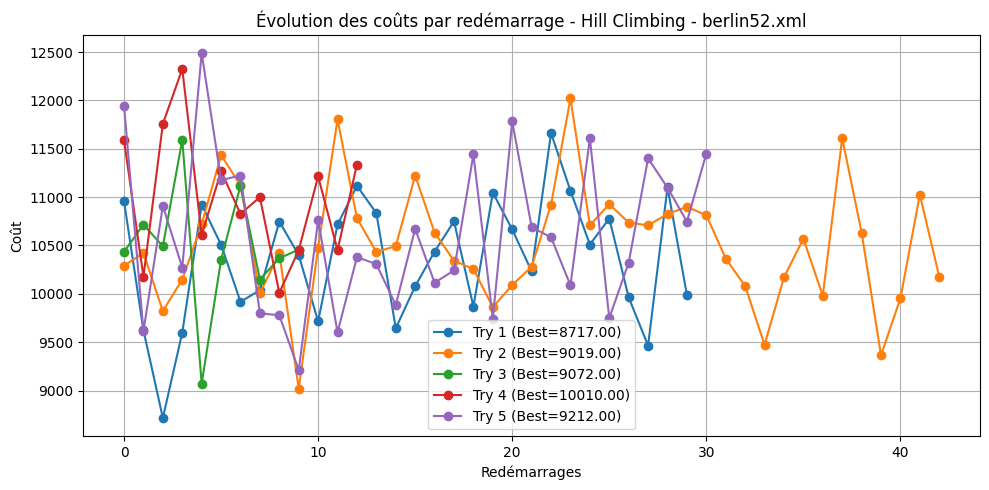

In [ ]:
best_hc, results_hc = try_multiple_hillclimbing(matrice_distances_liste, instance)
df_hc_results = visualize_hillclimbing_results(results_hc, instance)


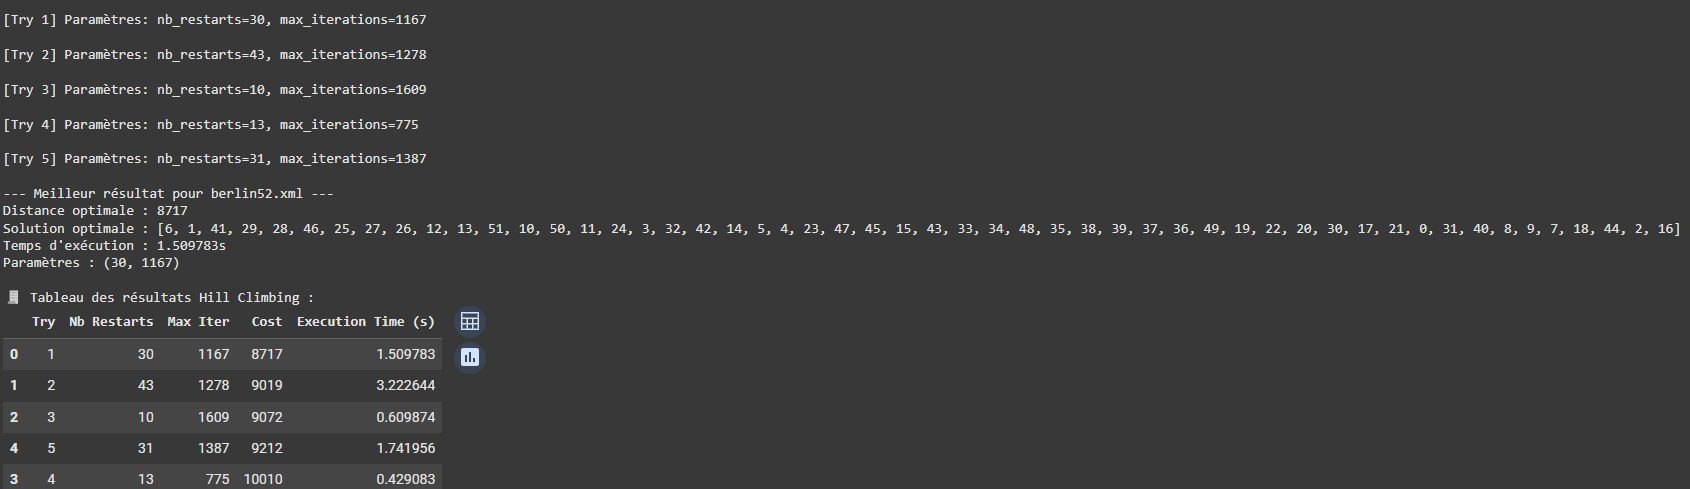

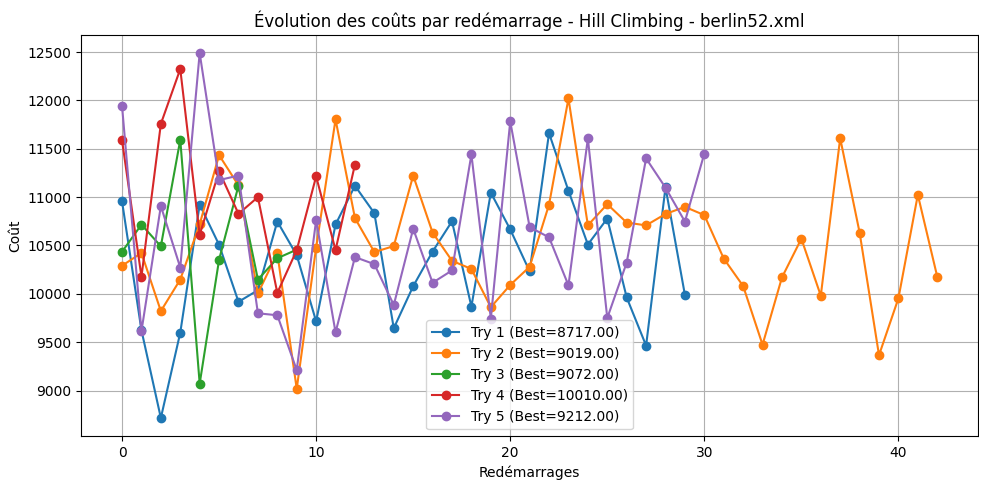

Comparaison avec ces différentes méthodes

In [ ]:
def comp_methods(sa_results, tabu_results, hc_results):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Construction du tableau résumé
    data = {
        'Méthode': ['Simulated Annealing', 'Tabu Search', 'Hill Climbing'],
        'Meilleur Coût': [
            min([r['cost'] for r in sa_results]),
            min([r['cost'] for r in tabu_results]),
            min([r['cost'] for r in hc_results])
        ],
        'Temps (s)': [
            min([r['time'] for r in sa_results]),
            min([r['time'] for r in tabu_results]),
            min([r['time'] for r in hc_results])
        ]
    }

    df_compare = pd.DataFrame(data)

    print("\nComparaison:")
    display(df_compare)

    # Bar plot comparatif
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Coût
    ax[0].bar(df_compare['Méthode'], df_compare['Meilleur Coût'], color='skyblue')
    ax[0].set_title('Comparaison du coût optimal')
    ax[0].set_ylabel('Distance minimale trouvée')
    ax[0].grid(True)

    # Temps
    ax[1].bar(df_compare['Méthode'], df_compare['Temps (s)'], color='lightcoral')
    ax[1].set_title('Comparaison des temps d\'exécution')
    ax[1].set_ylabel('Temps (s)')
    ax[1].grid(True)

    plt.suptitle("Comparaison globale des Métaheuristiques", fontsize=14)
    plt.tight_layout()
    plt.show()

    return df_compare



Comparaison:


,Méthode,Meilleur Coût,Temps (s)
0,Simulated Annealing,9365,0.017303
1,Tabu Search,9056,3.823087
2,Hill Climbing,8717,0.429083


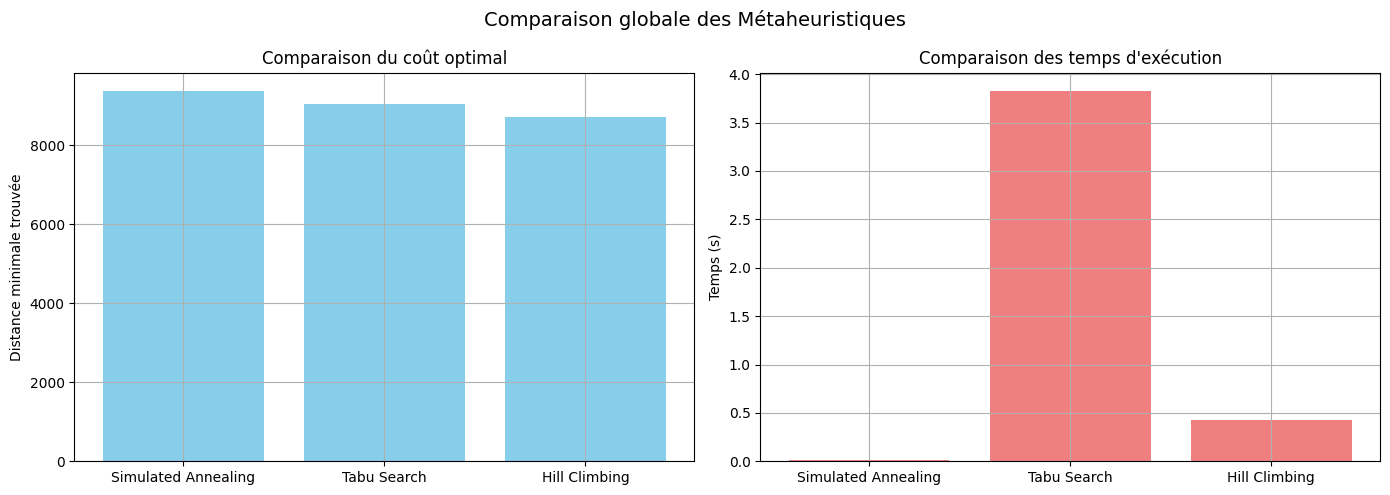

In [ ]:
df_comparaison = comp_methods(results, results_tabu, results_hc)


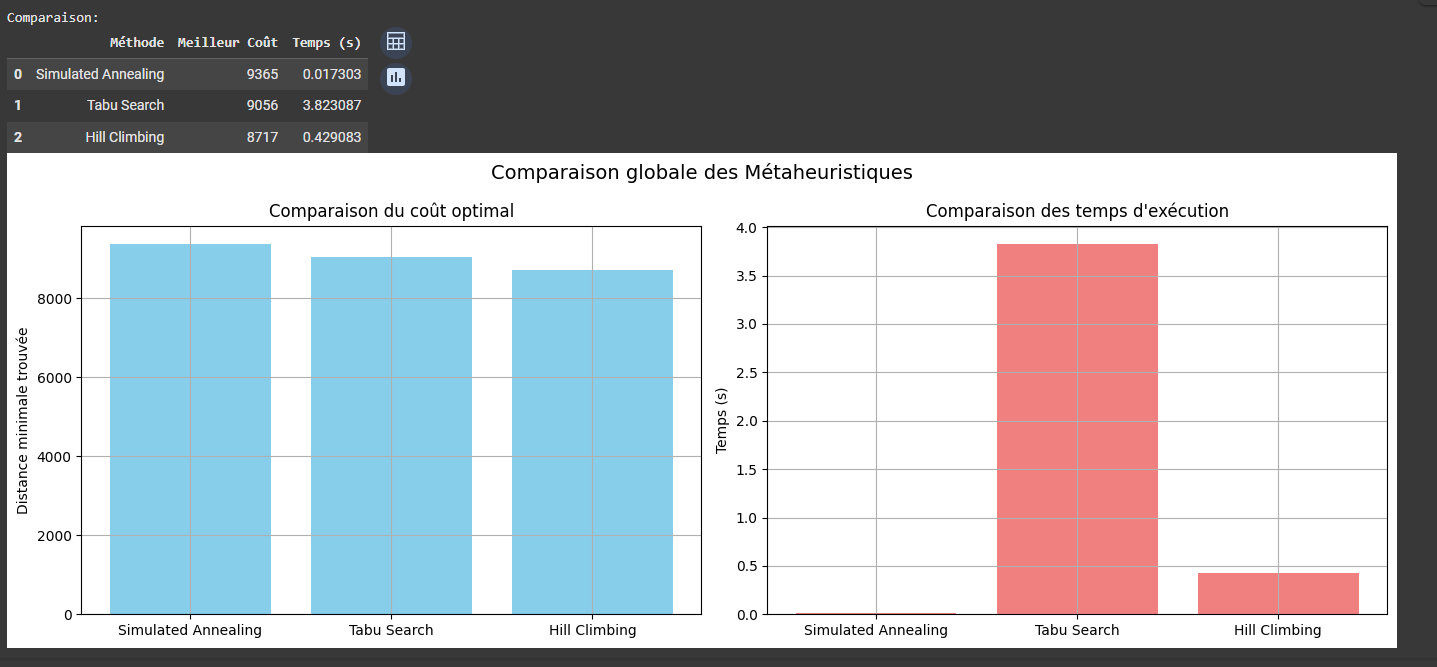

**démarche pour tester**

* Afin d’analyser l’impact des paramètres sur les performances des différentes métaheuristiques **(Recuit Simulé, Recherche Tabou, Hill Climbing)**, nous avons adopté une approche empirique systématique.
ce qui nous a permis d’évaluer l’efficacité de chaque méthode implémentée dans différentes configurations possibles, et d’identifier les plages de paramètres menant à de meilleures solutions.

* Pour chaque méthode, nous avons réalisé plusieurs essais indépendants (souvent 5 à 10), en faisant varier les paramètres aléatoirement dans des intervalles raisonnables, définis d'après la littérature et des tests préliminaires.




* Les plages ont été choisies pour couvrir un bon équilibre entre exploration, intensification, et temps de calcul raisonnable.

Nous avons appliqué trois approches de métaheuristiques (recuit simulé, recherche tabou et hill climbing avec redémarrages) sur le même ensemble de données PVC.

* La comparaison (voir tableau et graphique) montre que :

* Le recuit simulé donne souvent la meilleure solution en termes de qualité (coût le plus bas), avec un temps raisonnable.

* La recherche tabou est plus rapide dans certains cas, mais parfois moins optimale.

* Le hill climbing est le plus simple et rapide, mais souffre de pièges de minimums locaux (forte variabilité entre redémarrages).

* Le recuit simulé semble donc offrir le meilleur compromis entre qualité et stabilité pour cette instance.